In [21]:
import numpy as numpy
import os, shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import image
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, Model

In [22]:
# if not os.path.isdir("val_images"):
#     os.mkdir("val_images")

In [23]:
# classes = ['COVID-19', 'NORMAL', 'Viral Pneumonia']

In [24]:
# for c in classes:
#     if not os.path.isdir("val_images/" + c):
#         os.mkdir("val_images/" + c)

In [25]:
# split = 0.9
# for dirc in os.listdir("images"):
#     p = "images/" + dirc
#     imgs = os.listdir(p)
#     split_size = int(len(imgs)*split)
#     files_to_move =  imgs[split_size:]
#     print(files_to_move)
#     print()
#     for f in files_to_move:
#         src = os.path.join(p,f)
#         dest = os.path.join("val_images/",dirc)
#         shutil.move(src,dest)

### Image Augmentation

In [26]:
train_datagen = image.ImageDataGenerator(rotation_range=0.25,
                                         width_shift_range=0.25,
                                         height_shift_range=0.25,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         preprocessing_function=preprocess_input)

In [27]:
val_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)

In [28]:
train_generator = train_datagen.flow_from_directory("./images",
                                                     target_size=(224,224),
                                                     class_mode="categorical",
                                                     shuffle=True,
                                                     batch_size=64
                                                     )

Found 2613 images belonging to 3 classes.


In [29]:
train_generator.class_indices

{'COVID-19': 0, 'NORMAL': 1, 'Viral Pneumonia': 2}

In [30]:
d, l = next(train_generator)

In [31]:
d.shape, l.shape

((64, 224, 224, 3), (64, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[0. 1. 0.]


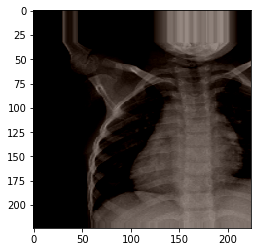

In [32]:
plt.imshow(d[0].astype('int32'))
print(l[0])

In [33]:
val_generator = val_datagen.flow_from_directory("./val_images",
                                                 target_size=(224, 224),
                                                 class_mode="categorical",
                                                 batch_size = 64
                                                 )

Found 292 images belonging to 3 classes.


### Model Building

In [34]:
vgg = VGG19(include_top = False, weights = "imagenet", input_shape=(224,224,3))

In [35]:
headModel = vgg.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(32, activation='relu')(headModel)
headModel = Dropout(0.3)(headModel)
headModel = BatchNormalization()(headModel)
headModel = Dense(3, activation="softmax")(headModel)

In [36]:
model = Model(inputs = vgg.input, outputs = headModel)

In [37]:
for l in vgg.layers:
    l.trainable = False

model.compile(optimizer="Adam", loss = "categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [38]:
hist = model.fit(train_generator, 
                           steps_per_epoch=2613//64,
                           validation_data=val_generator, 
                           validation_steps=292//64, 
                           epochs=12)

Epoch 1/12
40/40 [==============================] - 770s 19s/step - loss: 0.8697 - accuracy: 0.6304 - val_loss: 0.5779 - val_accuracy: 0.8672
Epoch 2/12
40/40 [==============================] - 788s 20s/step - loss: 0.4891 - accuracy: 0.8337 - val_loss: 0.3205 - val_accuracy: 0.9219
Epoch 3/12
40/40 [==============================] - 801s 20s/step - loss: 0.3697 - accuracy: 0.8809 - val_loss: 0.3366 - val_accuracy: 0.9141
Epoch 4/12
40/40 [==============================] - 805s 20s/step - loss: 0.3231 - accuracy: 0.9007 - val_loss: 0.4029 - val_accuracy: 0.8867
Epoch 5/12
40/40 [==============================] - 801s 20s/step - loss: 0.3002 - accuracy: 0.9043 - val_loss: 0.1752 - val_accuracy: 0.9414
Epoch 6/12
40/40 [==============================] - 814s 20s/step - loss: 0.2745 - accuracy: 0.9192 - val_loss: 0.3018 - val_accuracy: 0.9141
Epoch 7/12
40/40 [==============================] - 852s 21s/step - loss: 0.2580 - accuracy: 0.9184 - val_loss: 0.1767 - val_accuracy: 0.9492
Epoch 

In [39]:
model.evaluate(val_generator)

5/5 [==============================] - 59s 12s/step - loss: 0.2534 - accuracy: 0.9247


[0.2534155249595642, 0.9246575236320496]

In [40]:
model.save("xray.h5")